In [1]:
import torch
from torchdiffeq import odeint
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time
import numpy as np
import pickle
from scripts.utils import set_seed
from scripts.ds_class import *
from scripts.homeos import *
from scripts.plotting import *
from scripts.fit_motif import *
from scripts.time_series import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import seaborn as sns

set_seed(313)
save_dir = 'experiments/all_sources'

dt=0.01
time_span=torch.tensor([0, 1])
simulation_params = {
        'initial_conditions_mode': 'random',
        'number_of_target_trajectories': 50,
        'time_span': time_span,
        'dt': dt,
        'noise_std': 0.0,
        'training_pairs': False,
        'margin': 0.5,
        'seed': 42,
        'train_ratio': .8    }

def torus_4d_to_3d(torus_4d: np.ndarray, R: float = 2.0, r: float = 1.0) -> np.ndarray:
    """
    Converts 4D embedded torus points (cosθ, sinθ, cosφ, sinφ) into 3D torus coordinates.
    
    Args:
        torus_4d: np.ndarray of shape (N, 4)
        R: Major radius of the torus
        r: Minor radius of the torus

    Returns:
        np.ndarray of shape (N, 3)
    """
    x1, x2, x3, x4 = torus_4d[:, 0], torus_4d[:, 1], torus_4d[:, 2], torus_4d[:, 3]

    theta = np.arctan2(x2, x1)
    phi = np.arctan2(x4, x3)

    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)

    return np.stack([x, y, z], axis=-1)


In [2]:
### LDS
dim=2
dt=0.01
time_span=torch.tensor([0, 1])
#make system 
generator_sys = AnalyticalLinearSystem(dim=dim, dt=dt, time_span=time_span) 
inv_man = generator_sys.invariant_manifold().detach().numpy()

C:\Users\abel_\AppData\Local\Temp\ipykernel_12912\1601517428.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bi_traj = generator_sys.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32)).detach().numpy()


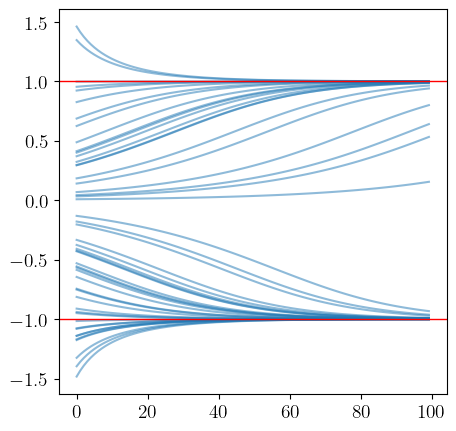

In [3]:
### Bistable
dim=1
dt=0.01
time_span=torch.tensor([0, 1])
#make system 
generator_sys = AnalyticalBistableSystem(dim=dim, dt=dt, time_span=time_span, alpha_init=-3) 
init_conds = generate_initial_conditions(sampling_method='uniform', num_points=50, bounds=[(-1.5, 1.5)]*3, seed=simulation_params['seed'])
bi_traj = generator_sys.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32)).detach().numpy()

inv_man = generator_sys.invariant_manifold().detach().numpy()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# horizontal line
for i in range(0, len(bi_traj)):
    ax.plot(bi_traj[i, :, 0], '-', color='C0', markersize=2, alpha=0.5)

ax.axhline(inv_man[0], color='red', lw=1)
ax.axhline(inv_man[1], color='red', lw=1);

3


C:\Users\abel_\AppData\Local\Temp\ipykernel_23632\3580870428.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alc = generator_ra.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32)).detach().numpy()


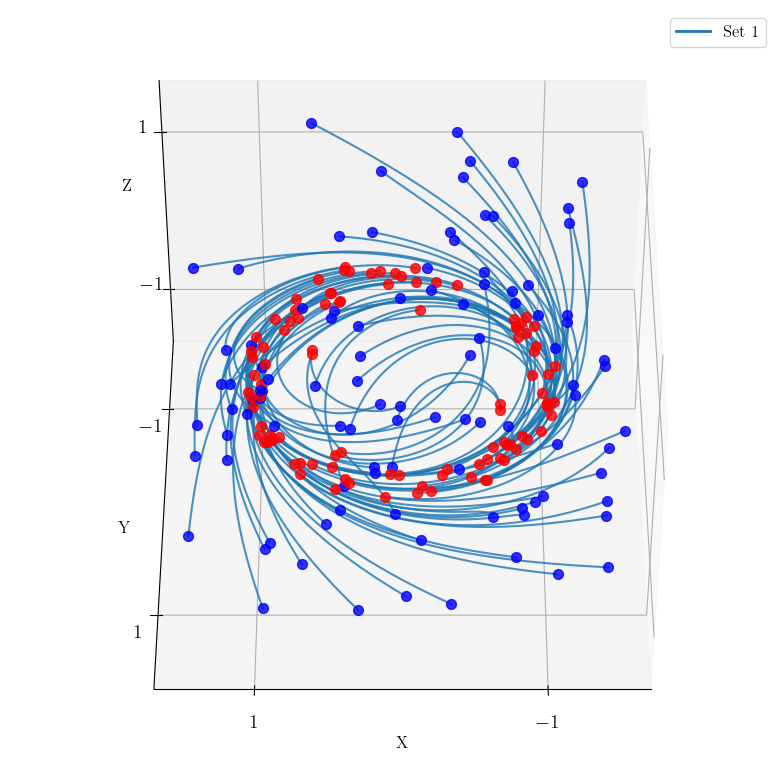

In [4]:
dt = 0.01
time_span = torch.tensor([0.0, 2.])
init_conds = generate_initial_conditions(sampling_method='uniform', num_points=100, bounds=[(-1.5, 1.5)]*3, seed=simulation_params['seed'])
generator_ra = AnalyticalLimitCycle(dim=3, dt=dt, time_span=time_span, velocity_init=-1, alpha_init=-1)
print(generator_ra.dim)
alc = generator_ra.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32)).detach().numpy()
plot_trajectories_3d([alc], elev=45, azim=90)
# fig, ax = plt.subplots(figsize=(5, 5))
# for i in range(alc.shape[0]):
#     if i % 10 == 0:
#         ax.plot(alc[i, :, 0], alc[i, :, 1], 'o', color='black', markersize=2, alpha=0.5)
# plt.show()
# fig, ax = plt.subplots(figsize=(5, 5))
# for i in range(alc.shape[0]):
#     if i % 10 == 0:
#         ax.plot(alc[i, :, 2],'o', color='black', markersize=2, alpha=0.5)
# plt.show()

### Ring attractor with vector field

In [46]:
ra_vfp = LearnableNDRingAttractor(dim=2, dt=dt, time_span=time_span*10, vf_on_ring_enabled=True)

#TrainablePeriodicFunction
init_conds = generate_initial_conditions(sampling_method='uniform', num_points=10, bounds=[(-1.25, 1.25)]*2, seed=simulation_params['seed'])
ra_trajs = ra_vfp.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32)).detach().numpy()
inv_man = ra_vfp.invariant_manifold().detach().numpy();

C:\Users\abel_\AppData\Local\Temp\ipykernel_23632\2638247453.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ra_trajs = ra_vfp.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32)).detach().numpy()


In [54]:
xs = np.linspace(0, 2*np.pi,25)
vf_xs = ra_vfp.vf_on_ring(torch.tensor(xs)).detach().numpy()
vf_xs_tang_x = -vf_xs * np.sin(xs)
vf_xs_tang_y = vf_xs * np.cos(xs)

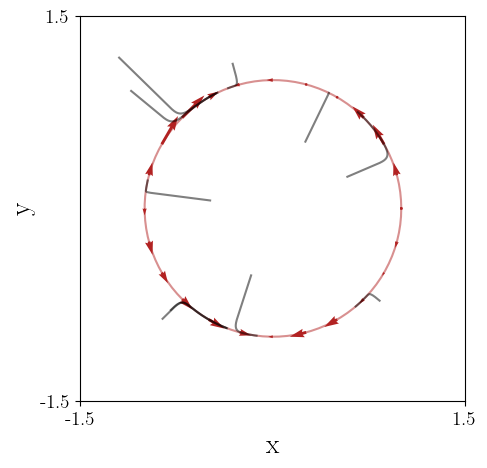

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
for i in range(ra_trajs.shape[0]):
    ax.plot(ra_trajs[i, :, 0], ra_trajs[i, :, 1], '-', color='black', markersize=2, alpha=0.5, zorder=100)

ax.quiver(np.cos(xs), np.sin(xs), vf_xs_tang_x, vf_xs_tang_y, color='firebrick', scale=.5)
ax.plot(inv_man[:, 0], inv_man[:, 1], '-', color='firebrick', markersize=2, alpha=0.5)
ax.set_aspect('equal')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.set_xticks([-1.5,1.5], [-1.5,1.5])
ax.set_yticks([-1.5,1.5], [-1.5,1.5]);

# 2D attractors in 3D

## Sphere

In [65]:
dim = 3
sphere_dim = 2
ds_params = {
        'ds_motif': 'sphere', 'dim': dim, 'dt': dt, 'time_span': time_span,
        'analytic': False, 'sphere_dim':sphere_dim}
generator_sphere = LearnableSphereAttractor(dim=dim, sphere_dim=sphere_dim, dt=dt, time_span=time_span) 
generator_sphere = AnalyticalSphereAttractor(dim=dim, sphere_dim=sphere_dim, dt=dt, time_span=time_span) 

init_conds = generate_initial_conditions(
    sampling_method='uniform',
    bounds=[(-1.5, 1.5)]*3,
    num_points= simulation_params['number_of_target_trajectories'],
    seed=simulation_params['seed'])
sphere_trajs = generator_sphere.compute_trajectory(init_conds);
inv_man = generator_sphere.invariant_manifold().detach().numpy();

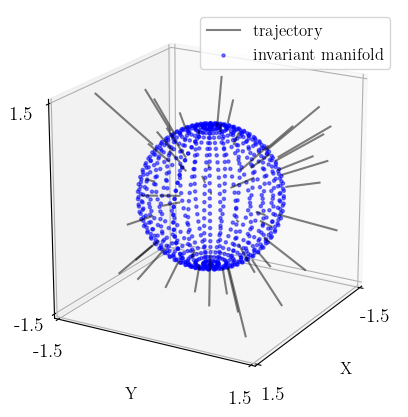

In [72]:
#plot invariant manifold
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': '3d'})
ax.set_box_aspect([1, 1, 1])  # aspect ratio is 1:1:1
for i in range(sphere_trajs.shape[0]):
    ax.plot(sphere_trajs[i, :, 0], sphere_trajs[i, :, 1], sphere_trajs[i,:,2], '-', color='black', markersize=2, alpha=0.5, zorder=100, label='trajectory' if i == 0 else "")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_zlim([-1.5, 1.5])
ax.set_xticks([-1.5, 1.5], [-1.5, 1.5])
ax.set_yticks([-1.5, 1.5], [-1.5, 1.5])
ax.set_zticks([-1.5, 1.5], [-1.5, 1.5])
ax.view_init(elev=20, azim=30)
ax.scatter(inv_man[:, 0], inv_man[:, 1], inv_man[:, 2], c='blue', s=5, alpha=0.5, label='invariant manifold')
ax.legend();

## Torus: Limit cycle + Ring attractor

In [ ]:
# composite system

# Define the 2D limit cycle system
limit_cycle = LearnableNDLimitCycle(
    dim=2,
    dt=0.05,
    time_span=(0, 5),
    velocity_init=1.0,
    alpha_init=-1.0
)

# Define the 2D ring attractor system
ring_attractor = LearnableNDRingAttractor(
    dim=2,
    dt=0.05,
    time_span=(0, 5),
    alpha_init=-1,
    sigma_init=0.05,
    vf_on_ring_enabled=False,
    vf_on_ring_num_terms=3
)

# Combine them into a composite system
composite_system = LearnableCompositeSystem(
    systems=[limit_cycle, ring_attractor],
    dims=[2, 2],
    dt=0.05,
    time_span=(0, 5)
)

# Run it
init_conds = generate_initial_conditions(
    sampling_method='uniform',bounds=[(-1.5, 1.5)]*4,num_points= simulation_params['number_of_target_trajectories'],seed=simulation_params['seed'])
torus_trajs = composite_system.compute_trajectory(init_conds).detach().numpy()
inv_man = composite_system.invariant_manifold(100).detach().numpy() #10 is coarse

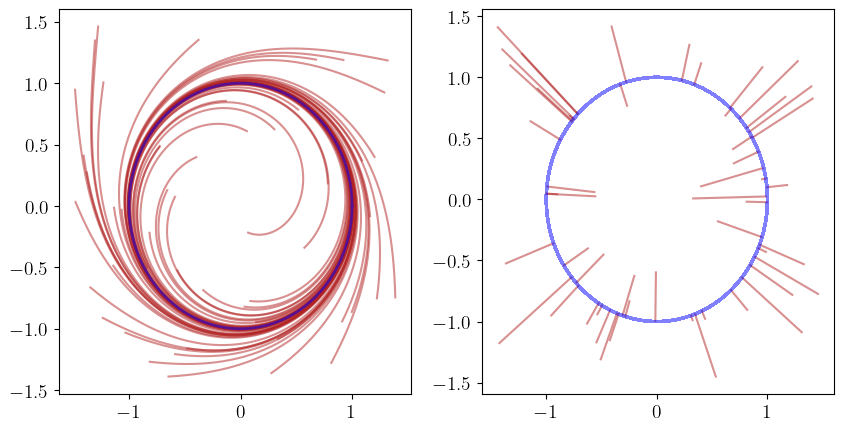

In [ ]:
#2subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(torus_trajs[:,:,0].T, torus_trajs[:,:,1].T, color='firebrick', alpha=0.5);
axs[0].plot(inv_man[:,0], inv_man[:,1], color='blue', alpha=0.5, lw=2)
axs[1].plot(torus_trajs[:,:,2,].T, torus_trajs[:,:,3].T, color='firebrick', alpha=0.5);
axs[1].plot(inv_man[:,2], inv_man[:,3], color='blue', alpha=0.5, lw=2)

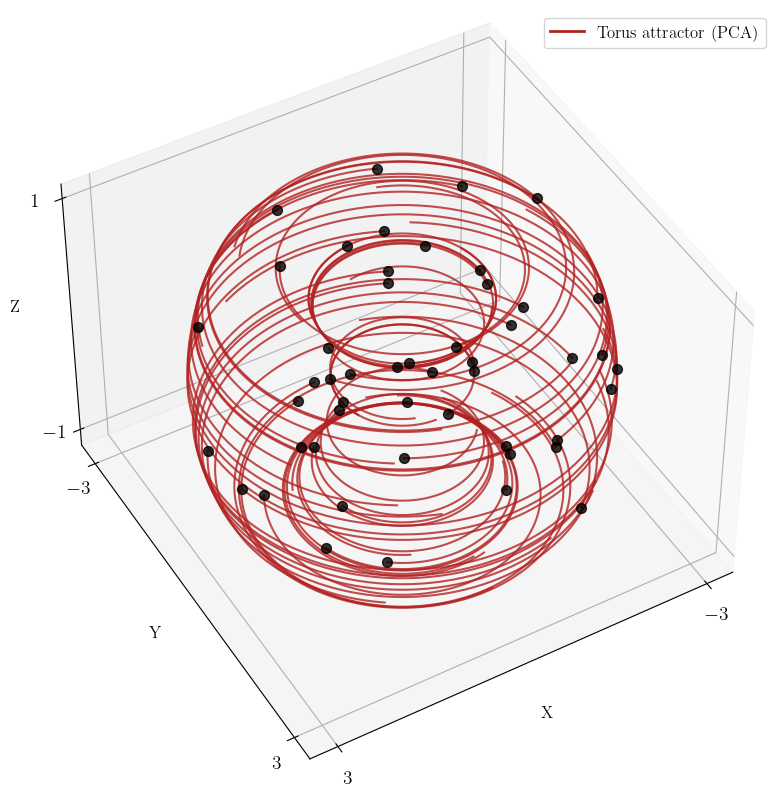

In [ ]:
# # pca 
# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# pca.fit(torus_trajs.detach().numpy().reshape(-1, 4))
# pca_trajs = pca.transform(torus_trajs.detach().numpy().reshape(-1, 4))

torus_3d = torus_4d_to_3d(torus_trajs.reshape(-1, 4))
inv_man_3d = torus_4d_to_3d(inv_man)

plot_trajectories_3d([torus_3d.reshape(torus_trajs.shape[0], torus_trajs.shape[1], 3), inv_man_3d],
                     labels=['Torus attractor (PCA)'],
                     colors=['firebrick'],
                     #save_name='torus_trajs.pdf',
                       elev=45, azim=60)

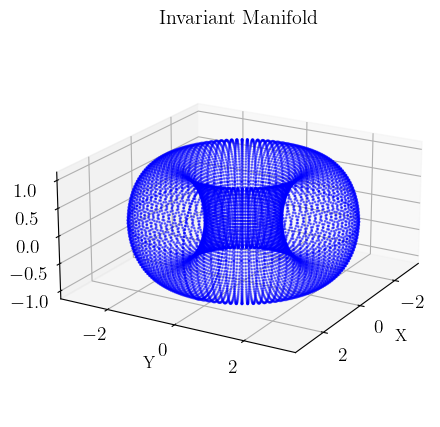

In [ ]:
#plot invariant manifold
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': '3d'})
ax.set_box_aspect([1, 1, .5])  # aspect ratio is 1:1:1
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Invariant Manifold')
ax.view_init(elev=20, azim=30)
ax.scatter(inv_man_3d[:, 0], inv_man_3d[:, 1], inv_man_3d[:, 2], c='blue', s=1, alpha=0.5)

## Torus: 2 Limit cycles

In [14]:
# Define the 2D limit cycle system
lc1 = LearnableNDLimitCycle(
    dim=2,
    dt=0.05,
    time_span=(0, 5),
    velocity_init=1.0,
    alpha_init=-1.0
)

# Define the 2D ring attractor system
lc2 = LearnableNDLimitCycle(
    dim=2,
    dt=0.05,
    time_span=(0, 5),
    velocity_init=.56546734,
    alpha_init=-1.0
)

# Combine them into a composite system
systems = [lc1, lc2]
dims = [lc1.dim, lc2.dim]
composite_system = LearnableCompositeSystem(
    systems=systems,
    dims=dims,
    dt=0.05,
    time_span=(0, 5)
)

# Run it
init_conds = generate_initial_conditions(sampling_method='uniform',bounds=[(-1.01, 1.01)]*sum(dims),num_points= simulation_params['number_of_target_trajectories'],seed=simulation_params['seed'])
torus_trajs = composite_system.compute_trajectory(init_conds).detach().numpy()
inv_man = composite_system.invariant_manifold(10).detach().numpy() 

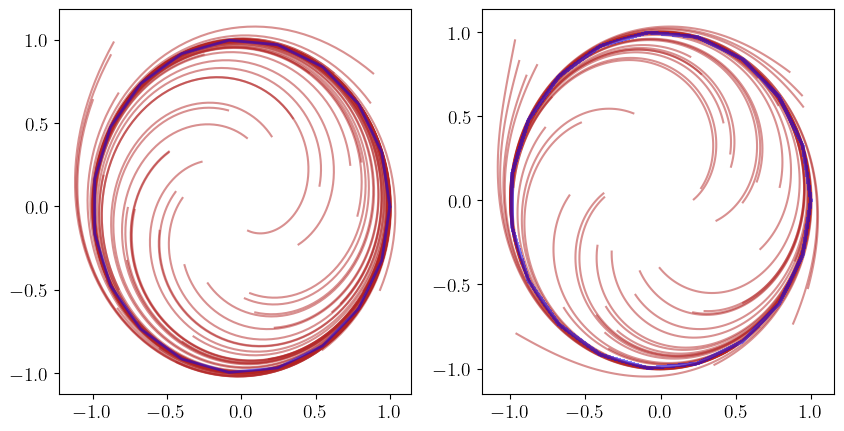

In [15]:
#2subplots
inv_man = composite_system.invariant_manifold(20).detach().numpy() 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(torus_trajs[:,:,0].T, torus_trajs[:,:,1].T, color='firebrick', alpha=0.5);
axs[0].plot(inv_man[:,0], inv_man[:,1], color='blue', alpha=0.5, lw=2)
axs[1].plot(torus_trajs[:,:,2,].T, torus_trajs[:,:,3].T, color='firebrick', alpha=0.5);
axs[1].plot(inv_man[:,2], inv_man[:,3], color='blue', alpha=0.5, lw=2)

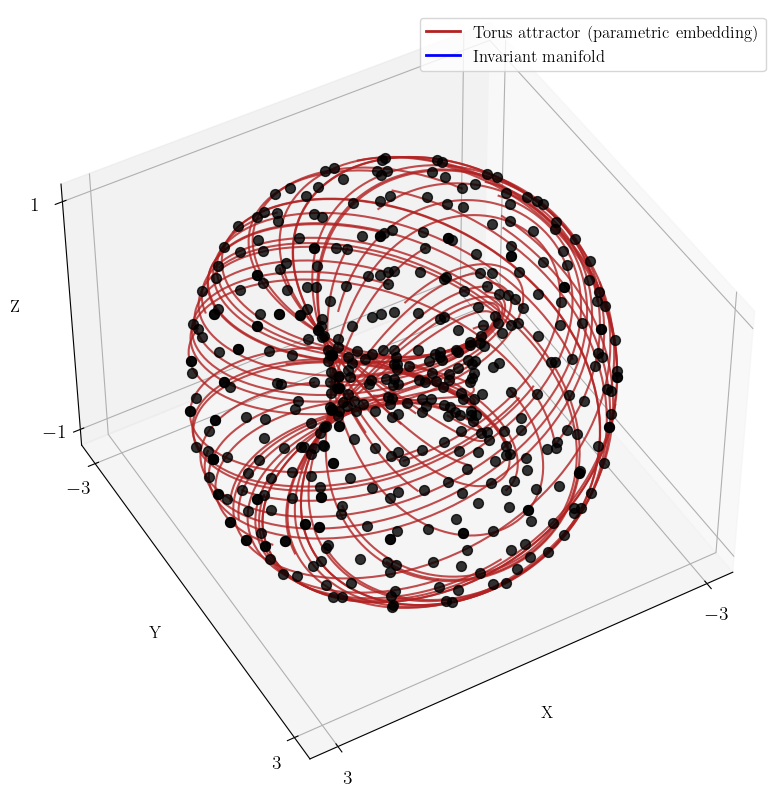

In [ ]:
torus_3d = torus_4d_to_3d(torus_trajs.reshape(-1, 4), R=2.0, r=1)
inv_man_3d = torus_4d_to_3d(inv_man)
plot_trajectories_3d([torus_3d.reshape(torus_trajs.shape[0], torus_trajs.shape[1], 3), inv_man_3d.reshape(inv_man_3d.shape[0], 1, 3)],
                     labels=['Torus attractor (parametric embedding)', 'Invariant manifold'],
                     colors=['firebrick', 'blue'],
                     #save_name='torus_trajs.pdf',
                       elev=45, azim=60)

## Cylinder

In [ ]:
lc = LearnableNDLimitCycle(
    dim=2,
    dt=0.05,
    time_span=(0, 5),
    velocity_init=1.0,
    alpha_init=-1.0
)

la = LearnableBoundedContinuousAttractor(
    dim=1,
    bca_dim=1,
    dt=0.05,
    time_span=(0, 5))

# Combine them into a composite system
systems = [lc, la]
dims = [lc.dim, la.dim]
composite_system = LearnableCompositeSystem(
    systems=systems,
    dims=dims,
    dt=0.05,
    time_span=(0, 5)
)

# Run it
init_conds = generate_initial_conditions(sampling_method='uniform',bounds=[(-1.01, 1.01)]*sum(dims),num_points= simulation_params['number_of_target_trajectories'],seed=simulation_params['seed'])
cylinder_trajs = composite_system.compute_trajectory(init_conds).detach().numpy()
inv_man = composite_system.invariant_manifold(10).detach().numpy() 
inv_man.shape

(110, 3)

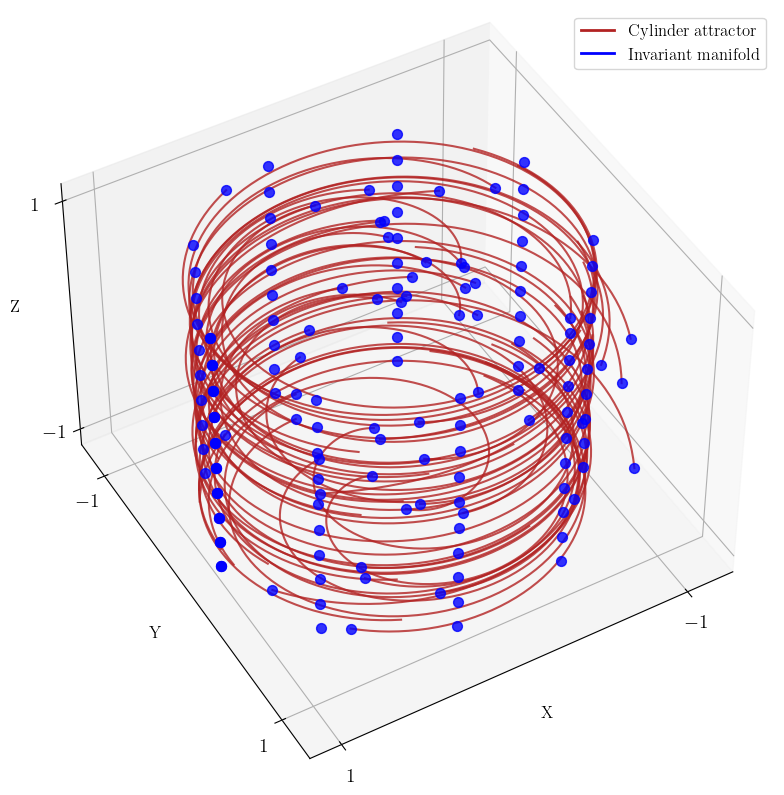

In [10]:
plot_trajectories_3d([cylinder_trajs, inv_man.reshape(inv_man.shape[0], 1, 3)],
                     labels=['Cylinder attractor', 'Invariant manifold'],
                     colors=['firebrick', 'blue'],
                     #save_name='cylinder_trajs.pdf',
                     plot_start=True, plot_end=False,
                       elev=45, azim=60)

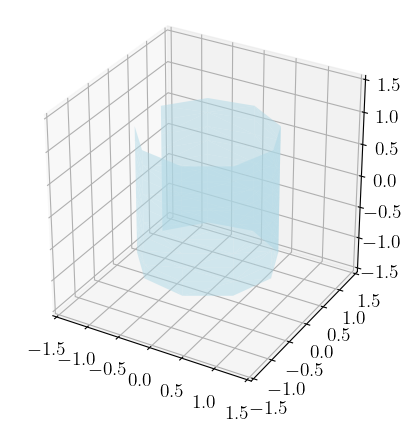

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={'projection': '3d'})
plot_deformed_cylinder_surface(ax, inv_man)

### 2 Line attractors

In [ ]:
bi_sys = LearnableNDBistableSystem(dim=dim, dt=dt, time_span=time_span) 
la = LearnableBoundedContinuousAttractor(dim=1,bca_dim=1,dt=0.05,time_span=(0, 5))
# Combine them into a composite system
systems = [bi_sys, la]
dims = [bi_sys.dim, la.dim]
composite_system = LearnableCompositeSystem(systems=systems,dims=dims,dt=0.05,time_span=(0, 5))

init_conds = generate_initial_conditions(sampling_method='uniform',bounds=[(-1.5, 1.5)]*sum(dims),num_points= simulation_params['number_of_target_trajectories'],seed=simulation_params['seed'])
bila_trajs = composite_system.compute_trajectory(init_conds).detach().numpy()
inv_man = composite_system.invariant_manifold(100).detach().numpy() 

array([[-1.        , -1.        ],
       [-1.        , -0.97979796],
       [-1.        , -0.959596  ],
       [-1.        , -0.93939394],
       [-1.        , -0.9191919 ],
       [-1.        , -0.8989899 ],
       [-1.        , -0.8787879 ],
       [-1.        , -0.85858583],
       [-1.        , -0.83838385],
       [-1.        , -0.8181818 ],
       [-1.        , -0.79797983],
       [-1.        , -0.7777778 ],
       [-1.        , -0.75757575],
       [-1.        , -0.73737377],
       [-1.        , -0.7171717 ],
       [-1.        , -0.69696975],
       [-1.        , -0.6767677 ],
       [-1.        , -0.65656567],
       [-1.        , -0.6363637 ],
       [-1.        , -0.61616164],
       [-1.        , -0.5959596 ],
       [-1.        , -0.5757576 ],
       [-1.        , -0.5555556 ],
       [-1.        , -0.53535354],
       [-1.        , -0.5151515 ],
       [-1.        , -0.4949495 ],
       [-1.        , -0.47474745],
       [-1.        , -0.45454544],
       [-1.        ,

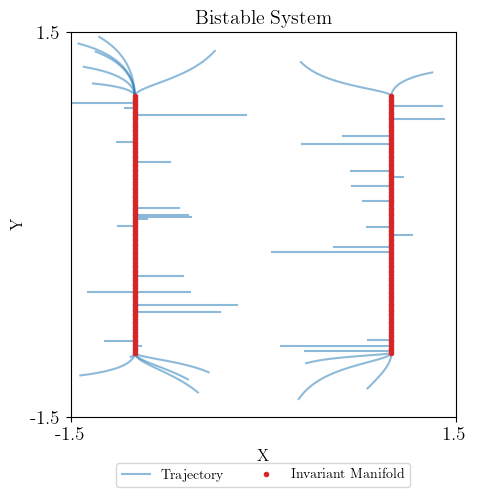

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(bila_trajs.shape[0]):
    ax.plot(bila_trajs[i, :, 0], bila_trajs[i, :, 1], '-', color='C0', label='Trajectory' if i == 0 else "", markersize=2, alpha=0.5)
ax.plot(inv_man[:, 0], inv_man[:, 1], '.', color='C3', lw=2, label='Invariant Manifold')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_xticks([-1.5, 1.5], [-1.5, 1.5])
ax.set_yticks([-1.5, 1.5], [-1.5, 1.5])
ax.set_aspect('equal')
ax.set_title('Bistable System')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10)

# Bounded Continuous Attractors

## Bounded Line attractor

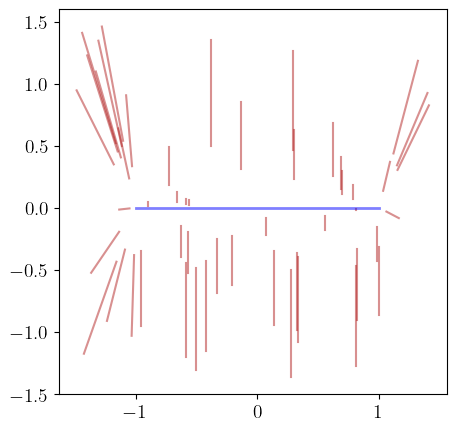

In [ ]:
dim = 2
bca_dim = 1
generator_bla = AnalyticalBoundedContinuousAttractor(dim=dim, bca_dim=bca_dim, dt=dt, time_span=time_span) 
init_conds = generate_initial_conditions(
    sampling_method='uniform',    bounds=[(-1.5, 1.5)]*dim,    num_points= simulation_params['number_of_target_trajectories'],    seed=simulation_params['seed'])
bla_trajs = generator_bla.compute_trajectory(init_conds).detach().numpy()
inv_man = generator_bla.invariant_manifold().detach().numpy();

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(bla_trajs[:, :, 0].T, bla_trajs[:, :, 1].T, color='firebrick', alpha=0.5);
ax.plot(inv_man[:, 0], inv_man[:, 1], color='blue', alpha=0.5, linewidth=2)
plt.show()

## Bounded Square Attractor (in R^2)

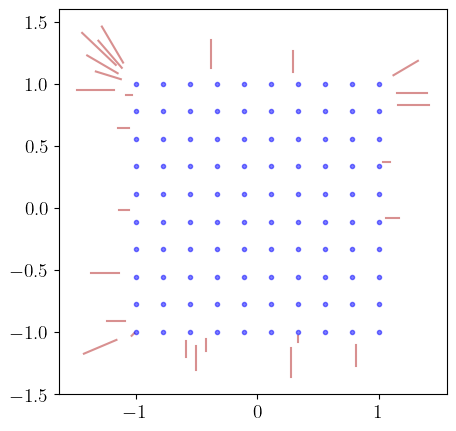

In [ ]:
dim = 2
bca_dim = 2
generator_bla = AnalyticalBoundedContinuousAttractor(dim=dim, bca_dim=bca_dim, dt=dt, time_span=time_span) 
init_conds = generate_initial_conditions(
    sampling_method='uniform',    bounds=[(-1.5, 1.5)]*dim,    num_points= simulation_params['number_of_target_trajectories'],    seed=simulation_params['seed'])
bsa_trajs = generator_bla.compute_trajectory(init_conds).detach().numpy()
inv_man = generator_bla.invariant_manifold().detach().numpy();

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(bsa_trajs[:, :, 0].T, bsa_trajs[:, :, 1].T, color='firebrick', alpha=0.5);
ax.plot(inv_man[:, 0], inv_man[:, 1], '.', color='blue', alpha=0.5, linewidth=2)
plt.show()

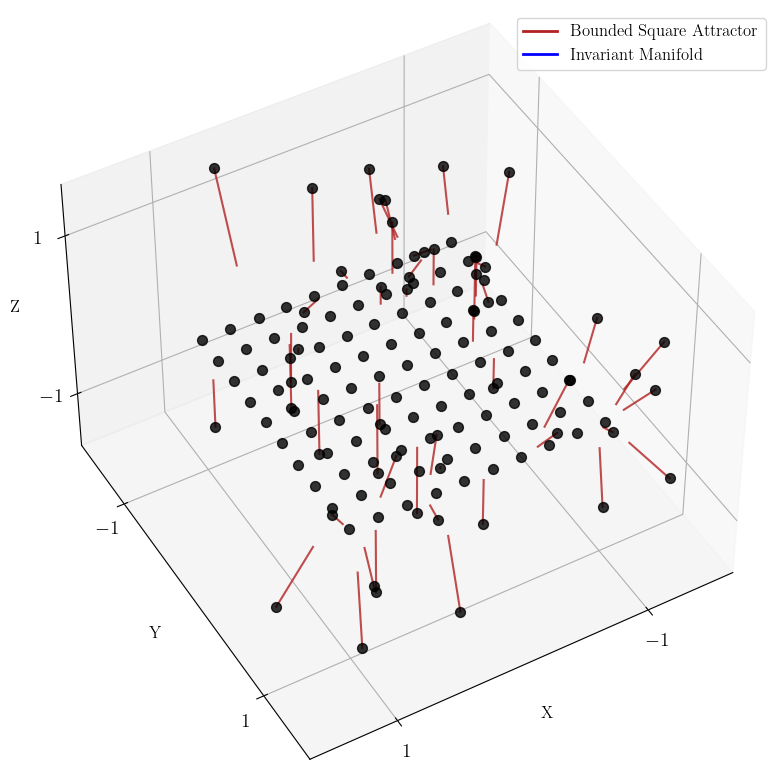

In [ ]:
## Bounded Square Attractor (in R^3)
dim = 3
bca_dim = 2
generator_bsa = AnalyticalBoundedContinuousAttractor(dim=dim, bca_dim=bca_dim, dt=dt, time_span=time_span) 
init_conds = generate_initial_conditions(
    sampling_method='uniform',    bounds=[(-1.5, 1.5)]*dim,    num_points= simulation_params['number_of_target_trajectories'],    seed=simulation_params['seed'])
bsa_trajs = generator_bsa.compute_trajectory(init_conds).detach().numpy()
inv_man = generator_bsa.invariant_manifold().detach().numpy();

plot_trajectories_3d([bsa_trajs, inv_man.reshape(-1, 1, 3)],
                     labels=['Bounded Square Attractor', 'Invariant Manifold'],
                     colors=['firebrick', 'blue'],
                     #save_name='bsa_trajs.pdf',
                       elev=45, azim=60)

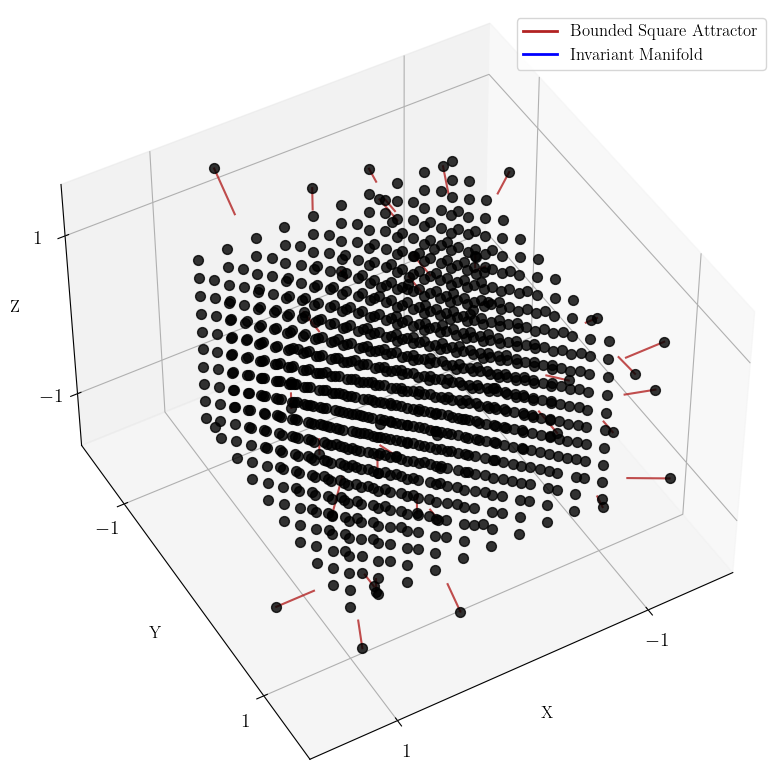

In [ ]:
## Bounded Cube Attractor (in R^3)
dim = 3
bca_dim = 3
generator_bsa = AnalyticalBoundedContinuousAttractor(dim=dim, bca_dim=bca_dim, dt=dt, time_span=time_span) 
init_conds = generate_initial_conditions(
    sampling_method='uniform',    bounds=[(-1.5, 1.5)]*dim,    num_points= simulation_params['number_of_target_trajectories'],    seed=simulation_params['seed'])
bsa_trajs = generator_bsa.compute_trajectory(init_conds).detach().numpy()
inv_man = generator_bsa.invariant_manifold().detach().numpy();

plot_trajectories_3d([bsa_trajs, inv_man.reshape(-1, 1, 3)],
                     labels=['Bounded Square Attractor', 'Invariant Manifold'],
                     colors=['firebrick', 'blue'],
                     #save_name='bsa_trajs.pdf',
                       elev=45, azim=60)